Website Traffic Analysis for LA City Infrastructure & Service Requests, this report offers insights into key metrics, including unique visitors, total sessions, and bounce rate, pertaining to lacity.org – the primary online platform serving the City of Los Angeles. The following analysis delves into the interpretation of these metrics and their implications for the city's digital presence and service accessibility.

All the Necessary Imports, Configs and Data

In [0]:
# Configs 
# File location and type
FILE_LOCATION = "/FileStore/tables/lacity_org_website_traffic.csv"
FILE_TYPE = "csv" 
INFER_SCHEMA = "false" 
FIRST_ROW_IS_HEADER = "true"
DELIMITER = ","

In [0]:
# Import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, dayofmonth, month, year
from pyspark.sql.functions import date_format, to_timestamp
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import seaborn as sns
from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram

In [0]:
# create spark instance SparkSession
spark = SparkSession.builder.appName('dataeng_week9').getOrCreate()

In [0]:
# Read the LA restaurant inspection data
la_tr = spark.read.format(FILE_TYPE) \
  .option("inferSchema", INFER_SCHEMA) \
  .option("header", FIRST_ROW_IS_HEADER) \
  .option("sep", DELIMITER) \
  .load(FILE_LOCATION)

display(la_tr)

DataFrame[Date: string, Device Category: string, Browser: string, # of Visitors: string, Sessions: string, Bounce Rate: string]

In [0]:
# convert date to dates
la_tr = la_tr.withColumn("timestamp", col("Date")).drop("Date")
la_tr = la_tr.withColumn("date", to_date(col("timestamp")))
la_tr = la_tr.withColumn("day", dayofmonth(col("date")))
la_tr = la_tr.withColumn("month", month(col("date")))  
la_tr = la_tr.withColumn("year", year(col("date")))
display(la_tr)

DataFrame[Device Category: string, Browser: string, # of Visitors: string, Sessions: string, Bounce Rate: string, timestamp: string, date: date, day: int, month: int, year: int]

Data Manipulation 


In [0]:
la_tr = la_tr.withColumn("hour", date_format(to_timestamp(col("timestamp")),"H")) \
             .withColumn("dayofweek", date_format(to_timestamp(col("timestamp")),"E"))

# A simple Window spec based on the Device category
windowSpec = Window.partitionBy("Device Category").orderBy("timestamp")

la_tr = la_tr.withColumn("row_num", F.row_number().over(windowSpec)) \
   .withColumn("rank", F.rank().over(windowSpec)) \
   .withColumn("dense_rank", F.dense_rank().over(windowSpec)) \
   .withColumn("count", F.count("*").over(windowSpec)) \
   .withColumn("first", F.first("# of Visitors").over(windowSpec)) \
   .withColumn("last", F.last("# of Visitors").over(windowSpec)) \
   .withColumn("min", F.min("# of Visitors").over(windowSpec)) \
   .withColumn("max", F.max("# of Visitors").over(windowSpec)) \
   .withColumn("nth", F.nth_value("# of Visitors", 2).over(windowSpec)) \
   .withColumn("lag", F.lag("# of Visitors", 1).over(windowSpec)) \
   .withColumn("lead", F.lead("# of Visitors", 1).over(windowSpec)) \
   .withColumn("percent", F.percent_rank().over(windowSpec)) \
   .withColumn("ntile", F.ntile(2).over(windowSpec)) \
   .orderBy("Device Category", "timestamp")
display(la_tr)

DataFrame[Device Category: string, Browser: string, # of Visitors: string, Sessions: string, Bounce Rate: string, timestamp: string, date: date, day: int, month: int, year: int, hour: string, dayofweek: string, row_num: int, rank: int, dense_rank: int, count: bigint, first: string, last: string, min: string, max: string, nth: string, lag: string, lead: string, percent: double, ntile: int]

Data Visualization 



In [0]:
# Convert to Pandas dataframe and some visuals
# pdf = la_tr.toPandas()
# ax = pdf.groupby('Device Category')[['# of Visitors']].sum().nlargest(10).plot.barh(x='Device Category', y='# of Visitors', title='Top 10 Device Categories')
# ax = pdf.set_index('date')[['# of Visitors']].plot(title='Daily Visitors') # Daily visitors trend
# ax = pdf.groupby('dayofweek')[['# of Visitors']].mean().plot.bar(title='Average Daily Visitors by Weekday') # Visitors by day of week
# ax = pdf.groupby('Browser')[['Bounce Rate']].mean().nlargest(10).plot.barh(x='Browser', y='Bounce Rate', title='Top 10 Browsers by Bounce Rate') # Top 10 browsers by bounce rate
# ax = pdf['Bounce Rate'].plot.hist(bins=20, title='Bounce Rate Distribution') # Bounce rate distribution
# ax = pdf.groupby([pdf['year'], pdf['month']])[['# of Visitors']].sum().unstack().plot(title='Monthly Visitors') # Monthly trends
# ax = pdf.groupby('hour')[['# of Visitors']].sum().plot(title='Hourly Visitors') # Hourly trends
# ax = pdf.plot.scatter(x='# of Visitors', y='Bounce Rate') # Scatter of visitors vs bounce rate
# ax = pdf.boxplot(column='Bounce Rate', by='Device Category') # Box plots of bounce rate by device 
# ax = pdf.set_index('timestamp')[['# of Visitors']].plot(title='Timeseries of Visitors') # Line plot of visitors over time
# plt.show()

In [0]:
# Plot directly from pyspark 
# Top 10 device categories by total visitors
la_tr = la_tr.withColumn("Sessions", la_tr["Sessions"].cast("int"))
la_tr = la_tr.withColumn("# of Visitors", la_tr["# of Visitors"].cast("int"))
la_tr = la_tr.withColumn("Bounce Rate", la_tr["Bounce Rate"].cast("int"))


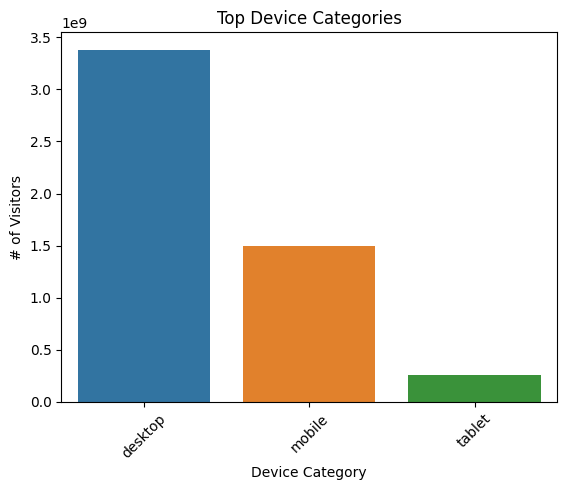

In [0]:

# Top device categories
top_device_categories = la_tr.groupBy("Device Category").sum("# of Visitors").toPandas()
sns.barplot(data=top_device_categories, x='Device Category', y='sum(# of Visitors)')
plt.xlabel('Device Category')
plt.ylabel('# of Visitors')
plt.title('Top Device Categories')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()


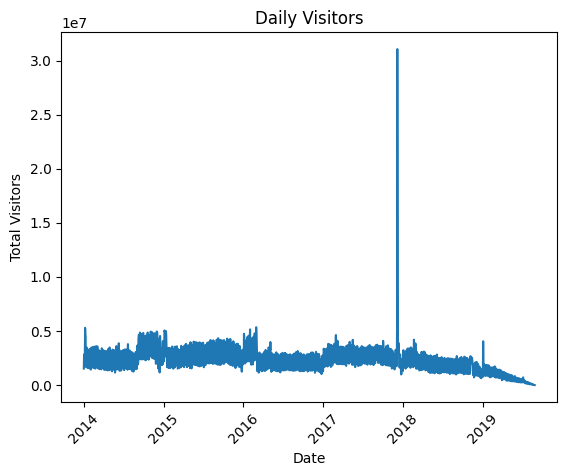

In [0]:
# Daily visitors
daily_visitors = la_tr.groupBy("date").sum("# of Visitors").toPandas()
sns.lineplot(data=daily_visitors, x="date", y="sum(# of Visitors)")
plt.xlabel('Date')
plt.ylabel('Total Visitors')
plt.title('Daily Visitors')
plt.xticks(rotation=45)
plt.show()

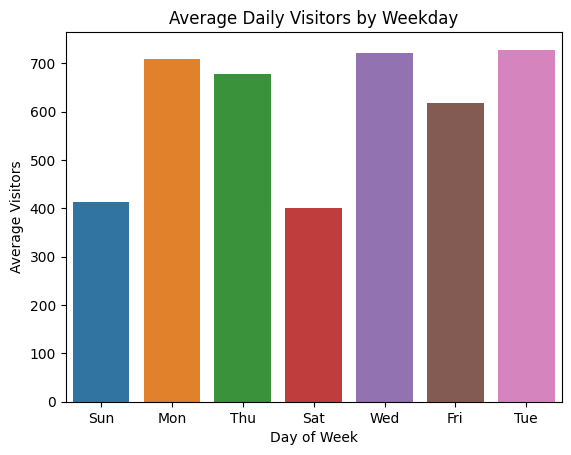

In [0]:
# Visitors by weekday
day_of_week_visitors = la_tr.groupBy("dayofweek").avg("# of Visitors").toPandas()
sns.barplot(data=day_of_week_visitors, x="dayofweek", y="avg(# of Visitors)")
plt.xlabel('Day of Week')
plt.ylabel('Average Visitors')
plt.title('Average Daily Visitors by Weekday')
plt.xticks(rotation=0)  # Rotate x-axis labels for readability
plt.show()

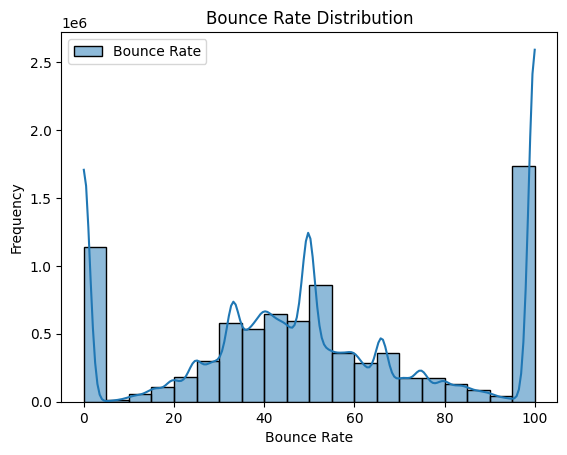

In [0]:
# Bounce rate distribution
bounce_rate_distribution = la_tr.select("Bounce Rate").toPandas()
sns.histplot(data=bounce_rate_distribution, bins=20, kde=True)
plt.xlabel('Bounce Rate')
plt.ylabel('Frequency')
plt.title('Bounce Rate Distribution')
plt.show()

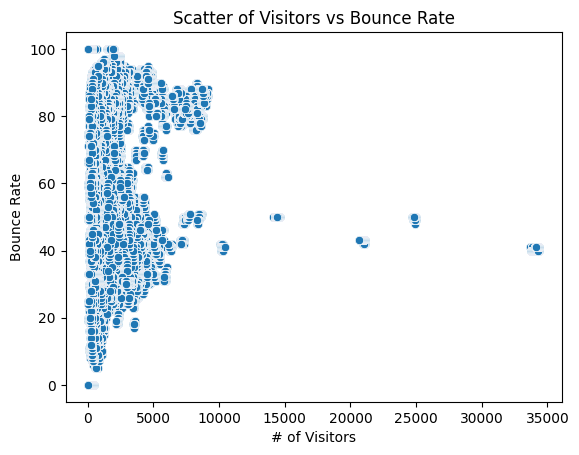

In [0]:
# Scatter visitors vs bounce
scatter_data = la_tr.select("# of Visitors", "Bounce Rate").toPandas()
sns.scatterplot(data=scatter_data, x="# of Visitors", y="Bounce Rate")
plt.xlabel('# of Visitors')
plt.ylabel('Bounce Rate')
plt.title('Scatter of Visitors vs Bounce Rate')
plt.show()

Conclusion 


After the peak in 2018, the traffic to lacity.org experienced a notable decrease. Several factors may have contributed to this decline, including:
- Decreased public engagement with news related to wildfires after the significant fires in 2018.
- Potential alterations to the website's structure, making it more challenging for users to locate desired information.
- A broader overarching trend of declining website traffic, likely influenced by the growing use of social media and alternative platforms for information retrieval.
- Despite the declining traffic, lacity.org remains a popular destination. It is imperative for the city to persist in enhancing the website's user experience to meet the evolving needs of its audience
